In [0]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [0]:
!mkdir ~/.kaggle

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c ml-marathon-final

  0% 0.00/9.12k [00:00<?, ?B/s]
100% 9.12k/9.12k [00:00<00:00, 7.99MB/s]
 91% 71.0M/78.3M [00:00<00:00, 77.5MB/s]
100% 78.3M/78.3M [00:00<00:00, 133MB/s] 


In [0]:
!ls

adc.json  data.zip  sample_data  sample_submission.csv


In [0]:
import zipfile

zip_ref = zipfile.ZipFile('data.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [0]:
!ls

adc.json  data.zip  kaggle_dogcat  sample_data	sample_submission.csv


#Preprocess Images

In [0]:
%matplotlib inline

import glob
import os
import re
import random

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
from PIL import Image

In [0]:
def norm_image(img):
    """
    Normalize PIL image
    
    Normalizes luminance to (mean,std)=(0,1), and applies a [1%, 99%] contrast stretch
    """
    img_y, img_b, img_r = img.convert('YCbCr').split()
    
    img_y_np = np.asarray(img_y).astype(float)

    img_y_np /= 255
    img_y_np -= img_y_np.mean()
    img_y_np /= img_y_np.std()
    scale = np.max([np.abs(np.percentile(img_y_np, 1.0)),
                    np.abs(np.percentile(img_y_np, 99.0))])
    img_y_np = img_y_np / scale
    img_y_np = np.clip(img_y_np, -1.0, 1.0)
    img_y_np = (img_y_np + 1.0) / 2.0
    
    img_y_np = (img_y_np * 255 + 0.5).astype(np.uint8)

    img_y = Image.fromarray(img_y_np)

    img_ybr = Image.merge('YCbCr', (img_y, img_b, img_r))
    
    img_nrm = img_ybr.convert('RGB')
    
    return img_nrm

In [0]:
def resize_image(img, size):
    """
    Resize PIL image
    
    Resizes image to be square with sidelength size. Pads with black if needed.
    """
    # Resize
    n_x, n_y = img.size
    if n_y > n_x:
        n_y_new = size
        n_x_new = int(size * n_x / n_y + 0.5)
    else:
        n_x_new = size
        n_y_new = int(size * n_y / n_x + 0.5)

    img_res = img.resize((n_x_new, n_y_new), resample=PIL.Image.BICUBIC)

    # Pad the borders to create a square image
    img_pad = Image.new('RGB', (size, size), (128, 128, 128))
    ulc = ((size - n_x_new) // 2, (size - n_y_new) // 2)
    img_pad.paste(img_res, ulc)

    return img_pad

In [0]:
TRAIN_DIR = './kaggle_dogcat/train/'
TRAIN_DOGS_DIR = './kaggle_dogcat/train/dogs'
TRAIN_CATS_DIR = './kaggle_dogcat/train/cats'

TEST_DIR = './kaggle_dogcat/test/'


train_dogs =   [TRAIN_DIR+'dogs/'+i for i in os.listdir(TRAIN_DOGS_DIR)]
train_cats =   [TRAIN_DIR+'cats/'+i for i in os.listdir(TRAIN_CATS_DIR)]

test_all =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]

train_all = train_cats + train_dogs

random.shuffle(train_all)

print(test_all)

['./kaggle_dogcat/test/249.jpg', './kaggle_dogcat/test/086.jpg', './kaggle_dogcat/test/367.jpg', './kaggle_dogcat/test/297.jpg', './kaggle_dogcat/test/250.jpg', './kaggle_dogcat/test/074.jpg', './kaggle_dogcat/test/095.jpg', './kaggle_dogcat/test/144.jpg', './kaggle_dogcat/test/211.jpg', './kaggle_dogcat/test/374.jpg', './kaggle_dogcat/test/106.jpg', './kaggle_dogcat/test/373.jpg', './kaggle_dogcat/test/146.jpg', './kaggle_dogcat/test/224.jpg', './kaggle_dogcat/test/161.jpg', './kaggle_dogcat/test/004.jpg', './kaggle_dogcat/test/047.jpg', './kaggle_dogcat/test/341.jpg', './kaggle_dogcat/test/110.jpg', './kaggle_dogcat/test/082.jpg', './kaggle_dogcat/test/033.jpg', './kaggle_dogcat/test/253.jpg', './kaggle_dogcat/test/200.jpg', './kaggle_dogcat/test/353.jpg', './kaggle_dogcat/test/115.jpg', './kaggle_dogcat/test/348.jpg', './kaggle_dogcat/test/001.jpg', './kaggle_dogcat/test/202.jpg', './kaggle_dogcat/test/263.jpg', './kaggle_dogcat/test/180.jpg', './kaggle_dogcat/test/158.jpg', './kagg

260


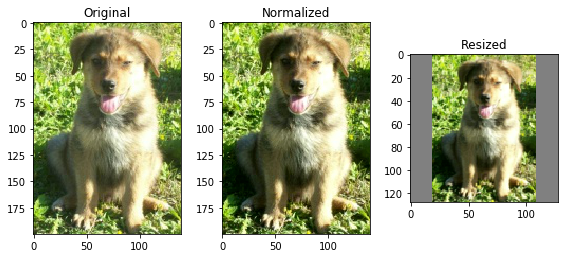

In [0]:
SIZE = 128  # for ImageNet models compatibility

# Read the image
choose_random_image = True
if choose_random_image:
    idx = np.random.randint(0, len(train_all))
else:
    idx = 24486
print(idx)
path = train_all[idx]
img = Image.open(path)

# Normalize it
img_nrm = norm_image(img)


# Resize it
img_res = resize_image(img_nrm, SIZE)

# Show it
plt.figure(figsize=(8,4))
plt.subplot(131)
plt.title('Original')
plt.imshow(img)

plt.subplot(132)
plt.title('Normalized')
plt.imshow(img_nrm)

plt.subplot(133)
plt.title('Resized')
plt.imshow(img_res)

plt.tight_layout()
plt.show()

In [0]:
ROWS = 128
COLS = 128
CHANNELS = 3

def read_image(file_path):
    # Normalize it
    img = Image.open(file_path)
    img_nrm = norm_image(img)

    # Resize it
    img_res = resize_image(img_nrm, ROWS)

    return img_res


def prep_data(images):
    count = len(images)
    data = np.ndarray((count,ROWS, COLS, CHANNELS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image
        if i%1000 == 0: print('Processed {} of {}'.format(i, count))
    
    return data
  


In [0]:
train = prep_data(train_all)
test = prep_data(test_all)

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Processed 0 of 4000
Processed 1000 of 4000
Processed 2000 of 4000
Processed 3000 of 4000
Processed 0 of 400
Train shape: (4000, 128, 128, 3)
Test shape: (400, 128, 128, 3)


Text(0.5, 1.0, 'Cats and Dogs')

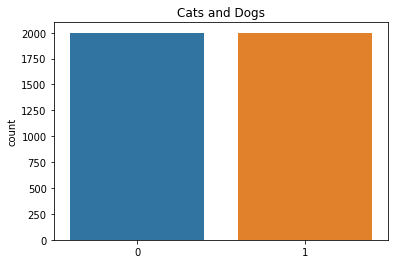

In [0]:
import seaborn as sns

labels = []
for i in train_all:
    if 'dogs' in i:
        labels.append(1)
    else:
        labels.append(0)

sns.countplot(labels)
plt.title('Cats and Dogs')

In [0]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping


Using TensorFlow backend.


In [0]:
def build_CNN(input_shape):
  
  input_layer = keras.layers.Input(input_shape)
  
  x = Conv2D(filters = 32, kernel_size = (3,3), padding = 'same')(input_layer)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters = 32, kernel_size = (3,3), padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D(pool_size = (2,2))(x)
  x = Dropout(0.25)(x)
  
  x = Conv2D(filters = 64, kernel_size = (3,3), padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters = 64, kernel_size = (3,3), padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D(pool_size = (2,2))(x)
  x = Dropout(0.25)(x)
  
  x = Conv2D(filters = 128, kernel_size = (3,3), padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters = 128, kernel_size = (3,3), padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D(pool_size = (2,2))(x)
  x = Dropout(0.25)(x)
  
  x = Flatten()(x)
  x = Dense(units = 512)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.25)(x)
  
  x = Dense(units = 256)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.25)(x)
  
  x = Dense(units = 128)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.25)(x)
  
  output_layer = Dense(units = 1, activation = 'sigmoid')(x)
  
  model = keras.models.Model( inputs = [input_layer], outputs = [output_layer])

  return model
  
  


In [0]:
cnn_model = build_CNN(train.shape[1:])
adam = keras.optimizers.Adam(lr = 0.001)
cnn_model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'], optimizer = RMSprop(lr=1e-4))
cnn_model.summary()

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, min_lr = 1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')        


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization_19 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
activation_19 (Activation)   (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_20 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
activation_20 (Activation)   (None, 128, 128, 32)      0         
__________

In [0]:
batch_size = 32
epochs = 100

In [0]:
history = cnn_model.fit(train, labels, batch_size=batch_size, nb_epoch=epochs,shuffle=True,
              validation_split=0.25,callbacks=[reduce_lr, early_stopping])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 3000 samples, validate on 1000 samples
Epoch 1/100
3000/3000 [==============================] - 11s 4ms/step - loss: 0.7073 - acc: 0.6047 - val_loss: 0.6539 - val_acc: 0.6170
Epoch 2/100
3000/3000 [==============================] - 8s 3ms/step - loss: 0.6350 - acc: 0.6667 - val_loss: 1.5884 - val_acc: 0.5380
Epoch 3/100
3000/3000 [==============================] - 8s 3ms/step - loss: 0.5719 - acc: 0.7043 - val_loss: 1.8693 - val_acc: 0.5470
Epoch 4/100
3000/3000 [==============================] - 8s 3ms/step - loss: 0.5191 - acc: 0.7507 - val_loss: 0.5899 - val_acc: 0.6980
Epoch 5/100
3000/3000 [==============================] - 8s 3ms/step - loss: 0.4524 - acc: 0.7880 - val_loss: 0.5586 - val_acc: 0.7440
Epoch 6/100
3000/3000 [==============================] - 8s 3ms/step - loss: 0.3861 - acc: 0.8283 - val_loss: 0.6866 - val_acc: 0.7220
Epoch 7/100
3000/3000 [==============================] - 8s 3ms/step - loss: 0.3267 - acc: 0.8653 - val_loss: 0.5623 - val_acc: 0.7370
Epoch 

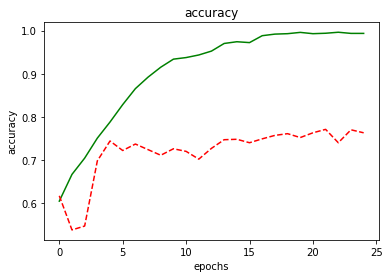

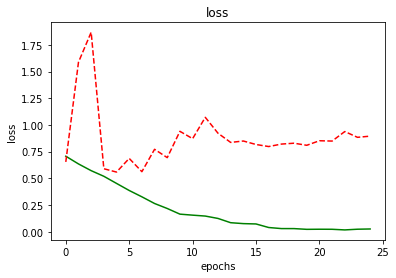

In [0]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'], '-', label = 'train_acc', color = 'g')
plt.plot(history.history['val_acc'],'--', label = 'valid_acc', color = 'r')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

plt.plot(history.history['loss'], '-', label = 'train_loss', color = 'g')
plt.plot(history.history['val_loss'],'--', label = 'valid_loss', color = 'r')
plt.title('loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [0]:
predictions = cnn_model.predict(test, verbose=0)

I am 96.26% sure this is a Dog


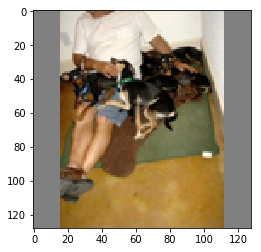

I am 91.91% sure this is a Dog


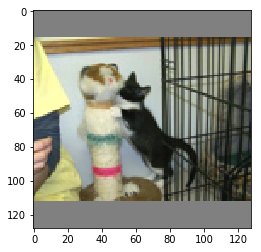

I am 82.61% sure this is a Dog


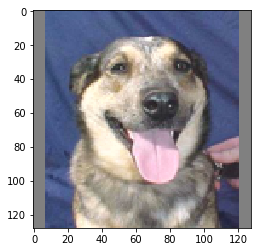

I am 62.11% sure this is a Cat


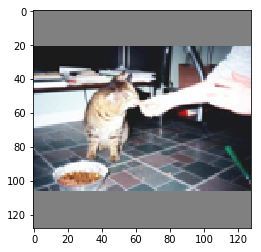

I am 99.90% sure this is a Dog


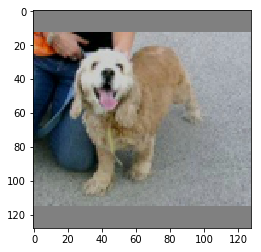

I am 91.62% sure this is a Dog


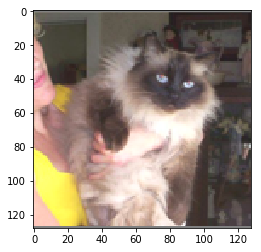

I am 99.35% sure this is a Dog


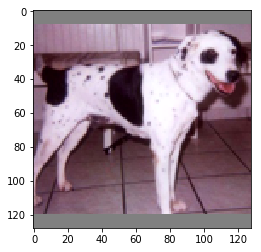

I am 100.00% sure this is a Cat


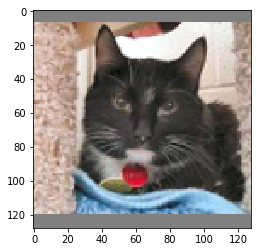

I am 99.99% sure this is a Dog


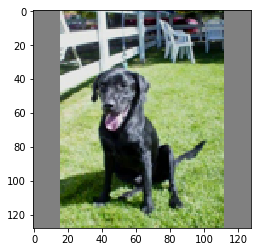

I am 99.94% sure this is a Cat


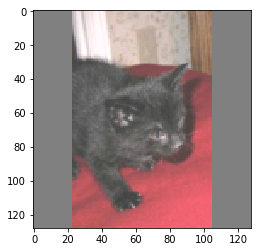

In [0]:
for i in range(0,10):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))
        
    plt.imshow(test[i])
    plt.show()

In [0]:
predicted_val = [p[0] for p in predictions]

In [0]:
id_line = []

for p in os.listdir(TEST_DIR):
  id_line.append(p.split(".")[0])

In [0]:
submission_df = pd.DataFrame({'ID':id_line, 'Predicted':predicted_val})

In [0]:
submission_df.to_csv("submission_v3.csv", index=False)

In [0]:
from google.colab import files

files.download('submission_v3.csv')